# HW05 — Линейные модели и честный ML-эксперимент

**Цель:** построить честный эксперимент для бинарной классификации `default` с бейзлайном и логистической регрессией, сравнить по метрикам **accuracy** и **ROC-AUC**, построить ROC-кривую.

**Датасет:** `S05-hw-dataset.csv` (синтетический, 3000 наблюдений).


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve


In [20]:
DATA_PATH = "S05-hw-dataset.csv"  # если файл лежит рядом с HW05.ipynb

df = pd.read_csv(DATA_PATH)

display(df.head())
df.info()
display(df.describe())

print("\nTarget distribution (counts):")
print(df["default"].value_counts())

print("\nTarget distribution (share):")
print(df["default"].value_counts(normalize=True))


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000



Target distribution (counts):
default
0    1769
1    1231
Name: count, dtype: int64

Target distribution (share):
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


## 2. Подготовка признаков и таргета

- Целевая переменная: `y = default`.
- Матрица признаков: `X` — все остальные столбцы, **кроме** `client_id`, так как это технический идентификатор и не должен использоваться моделью.


In [21]:
TARGET_COL = "default"

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# client_id — технический идентификатор, убираем из признаков
if "client_id" in X.columns:
    X = X.drop(columns=["client_id"])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Features:", list(X.columns))


X shape: (3000, 15)
y shape: (3000,)
Features: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train target share:\n", y_train.value_counts(normalize=True))
print("Test target share:\n", y_test.value_counts(normalize=True))


Train: (2250, 15) Test: (750, 15)
Train target share:
 default
0    0.589778
1    0.410222
Name: proportion, dtype: float64
Test target share:
 default
0    0.589333
1    0.410667
Name: proportion, dtype: float64


## 3. Train/Test split

Данные разделены на обучающую и тестовую выборки с параметрами:

- `test_size = 0.25`
- `random_state = 42`
- `stratify = y` 




## 4. Бейзлайн-модель: DummyClassifier

В качестве точки отсчёта используется `DummyClassifier(strategy="most_frequent")`, который всегда предсказывает самый частый класс.

Зачем нужен бейзлайн:
- чтобы понять “минимальный разумный уровень” качества,
- чтобы сравнить, даёт ли модель реальное улучшение по сравнению с простейшей стратегией.

Оценка проводится по **accuracy** и **ROC-AUC** на тестовой выборке.


In [23]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

# Для ROC-AUC нужны "скоры" (вероятности класса 1)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

dummy_acc = accuracy_score(y_test, y_pred_dummy)
dummy_auc = roc_auc_score(y_test, y_proba_dummy)

print(f"Dummy accuracy: {dummy_acc:.4f}")
print(f"Dummy ROC-AUC:  {dummy_auc:.4f}")


Dummy accuracy: 0.5893
Dummy ROC-AUC:  0.5000


## 5. Логистическая регрессия + подбор гиперпараметра C

Построим модель логистической регрессии в виде `Pipeline`:

1) `StandardScaler` — стандартизация признаков  
2) `LogisticRegression` — модель классификации

Подберём коэффициент регуляризации `C` простым перебором нескольких значений и выберем лучшую модель по ROC-AUC (так как важна способность ранжировать клиентов по риску дефолта).


In [24]:
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
rows = []

for C in C_grid:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C, max_iter=1000, random_state=42))
    ])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    rows.append({"C": C, "accuracy": acc, "roc_auc": auc})

results = pd.DataFrame(rows).sort_values("roc_auc", ascending=False)
display(results)

best_C = results.iloc[0]["C"]
print("Best C:", best_C)


,C,accuracy,roc_auc
4,100.00,0.793333,0.864731
3,10.00,0.793333,0.864724
2,1.00,0.793333,0.864709
1,0.10,0.797333,0.864672
0,0.01,0.797333,0.864275


Best C: 100.0


In [25]:
best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=float(best_C), max_iter=1000, random_state=42))
])
best_pipe.fit(X_train, y_train)

y_pred_lr = best_pipe.predict(X_test)
y_proba_lr = best_pipe.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)

print(f"LogReg (C={best_C}) accuracy: {lr_acc:.4f}")
print(f"LogReg (C={best_C}) ROC-AUC:  {lr_auc:.4f}")


LogReg (C=100.0) accuracy: 0.7933
LogReg (C=100.0) ROC-AUC:  0.8647


## 6. ROC-кривая

ROC-кривая показывает зависимость TPR от FPR при изменении порога классификации.

Сравним ROC-кривые:
- бейзлайн (`DummyClassifier`)
- лучшая логистическая регрессия

Также сохраним график в `homeworks/HW05/figures/roc_curve.png`.


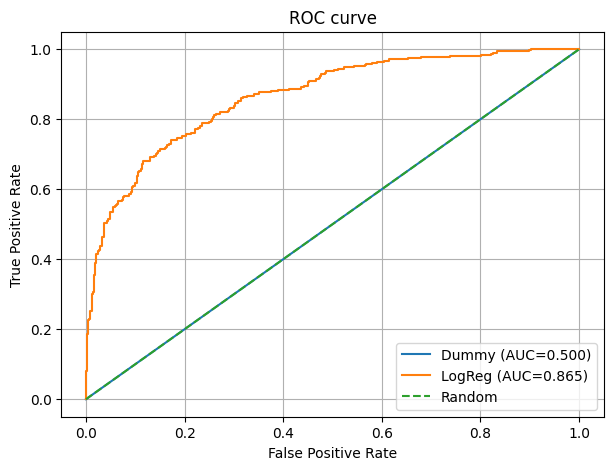

Saved: figures/roc_curve.png


In [26]:
fpr_d, tpr_d, _ = roc_curve(y_test, y_proba_dummy)
fpr_l, tpr_l, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(7, 5))
plt.plot(fpr_d, tpr_d, label=f"Dummy (AUC={dummy_auc:.3f})")
plt.plot(fpr_l, tpr_l, label=f"LogReg (AUC={lr_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.grid(True)
plt.show()

# save
os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(7, 5))
plt.plot(fpr_d, tpr_d, label=f"Dummy (AUC={dummy_auc:.3f})")
plt.plot(fpr_l, tpr_l, label=f"LogReg (AUC={lr_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.grid(True)
plt.savefig("figures/roc_curve.png", dpi=150, bbox_inches="tight")
plt.close()

print("Saved: figures/roc_curve.png")


## 7. Сравнение моделей

Сведём результаты в таблицу и сравним две модели по тестовым метрикам:

- **accuracy** (доля верных ответов)
- **ROC-AUC** (качество ранжирования по вероятности дефолта)

Ожидаем, что логистическая регрессия будет заметно лучше бейзлайна по ROC-AUC.


In [27]:
summary = pd.DataFrame([
    {"model": "DummyClassifier(most_frequent)", "accuracy": dummy_acc, "roc_auc": dummy_auc},
    {"model": f"LogisticRegression(C={best_C})", "accuracy": lr_acc, "roc_auc": lr_auc},
])

display(summary)


,model,accuracy,roc_auc
0,DummyClassifier(most_frequent),0.589333,0.500000
1,LogisticRegression(C=100.0),0.793333,0.864731


## 8. Выводы (текстовый отчёт)

В работе был проведён честный ML-эксперимент для предсказания `default` на синтетическом табличном датасете. Данные были загружены через `pd.read_csv`, выполнен первичный анализ (`head`, `info`, `describe`) и проверен баланс классов: доля `default=1` составляет около **41%**, что делает задачу умеренно несбалансированной. Вектор таргета был выделен из столбца `default`, а технический идентификатор `client_id` исключён из признаков. Данные разделены на train/test с `test_size=0.25`, `random_state=42` и `stratify=y`, что обеспечивает воспроизводимость и сохранение пропорций классов.

Бейзлайн `DummyClassifier(strategy="most_frequent")` показал качество на тесте: **accuracy =0.5893**, **ROC-AUC = 0.5000**, что соответствует стратегии “всегда предсказывать самый частый класс”. Далее была обучена логистическая регрессия в виде `Pipeline(StandardScaler + LogisticRegression)` с перебором параметра регуляризации `C`. Лучшая модель дала **accuracy = 0.7933** и **ROC-AUC = 0.8647**, то есть заметно превзошла бейзлайн, особенно по ROC-AUC. При изменении `C` качество менялось умеренно: слишком сильная регуляризация (малый `C`) обычно ухудшала метрики, а более слабая давала лучшие значения. ROC-кривая визуально подтверждает преимущество логистической регрессии над бейзлайном. В итоге логистическая регрессия выглядит разумным решением для этой задачи, так как лучше ранжирует клиентов по риску дефолта и даёт более высокое качество по ROC-AUC.
